### 4E1

y ~ Normal(mu, sigma)

### 4E2

Two parameters

### 4E3

$y_i \sim \rm{Normal}(\mu, \sigma)$

$\mu \sim \rm{Normal}(0, 10)$

$\sigma \sim \rm{Exponential}(1)$

$P(y | \mu{}, \sigma{})=\frac{\rm{Normal}(y | \mu{}, \sigma{})\rm{Normal}(\mu{} | 0, 10)\rm{Exponential}(\sigma | 1)}{\int{\rm{Normal}(y | \mu{}, \sigma{})\rm{Normal}(\mu{} | 0, 10)\rm{Exponential}(\sigma | 1)}dy}$

### 4E4

Second line

### 4E5

Four parameters ($\mu{}, \alpha{}, \beta{}, \sigma{}$)

In [1]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

/home/austin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


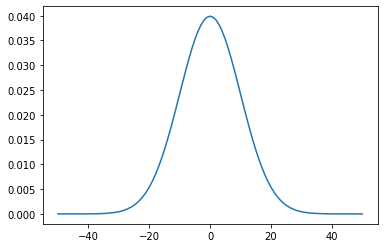

In [2]:
# 4M1

# visualising mu prior distribution
x_mu = torch.linspace(-50, 50, 101)
sns.lineplot(x_mu, dist.Normal(0, 10).log_prob(x_mu).exp());

/home/austin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


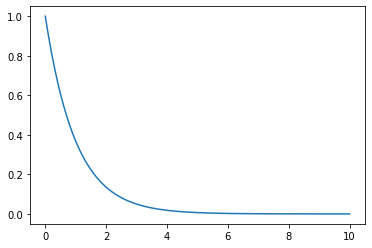

In [3]:
# visualising sigma prior distribution
x_sigma = torch.linspace(0, 10,101)
sns.lineplot(x_sigma, dist.Exponential(torch.tensor([1.0])).log_prob(x_sigma).exp());

/home/austin/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


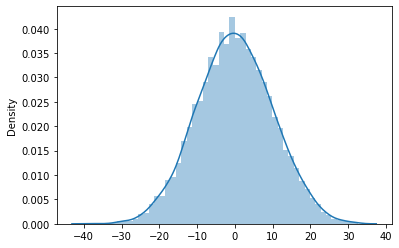

In [4]:
# prior predictive simulation for y

sample_mu = torch.empty(int(1e4)).normal_(0, 10)
sample_sigma = torch.empty(int(1e4)).exponential_(1)
prior_y = dist.Normal(sample_mu, sample_sigma).sample()
sns.distplot(prior_y);

### 4M2

In R:

```
ylist = alist(
    y ~ dnorm(mu, sigma),
    mu ~ dnorm(0, 10),
    sigma ~ exp(1)
)
```

In Python using Pyro:

```
def ylist(y):
    mu = pyro.sample("mu", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Exponential(1))
    with pyro.plate("plate"):
        pyro.sample("y", dist.Normal(mu, sigma), obs=y)
```

### 4M3

$y_i \sim \rm{Normal}(\mu, \sigma)$

$\mu = a + bx$

$a \sim \rm{Normal}(0, 10)$

$b \sim \rm{Uniform}(0, 1)$

$\sigma \sim \rm{Exponential}(1)$

### 4M4

$h_i \sim \rm{Normal}(\mu, \sigma)$

$\mu = a + by$

$a \sim \rm{Normal}(160, 20)$

$b \sim \rm{Normal}(0, 10)$

$\sigma \sim \rm{Normal}(0, 30)$

This mathematical model definition guesses that the average height for the students is 160cm with std.dev of 20cm. We guess that the year will have some small impact on the height relative to the mean and therefore use a normal dist with a small std.dev of 10. 

### 4M5

$b$ can no longer be negative so:

$b \sim \rm{Uniform}(0, 1)$

may be more appropriate now to capture the new information.

### 4M6

The current model uses a std dev for student height (20cm) that is larger than the std dev (8cm) if the variance is 64cm. I would update $a$ (default height) to capture this information:

$a \sim \rm{Normal}(160, 8)$

But I am not sure of my choice for the mean value so maybe I would leave it higher to account for that. All of this is assuming all of the students are the same age. If they are not, I am not sure what I'd do with this new information.

In [5]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

az.style.use("arviz-darkgrid")

In [6]:
# 4H1

raw = pd.read_csv("data/Howell_Kung.csv")
data = raw[raw["age"] >= 18]

# Define model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Train model
trained_model = AutoLaplaceApproximation(model)
svi = SVI(
    model, trained_model, optim.Adam(1), Trace_ELBO(), weight=data.weight.values, height=data.height.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
trained_parameters = svi.get_params(state)

# Summary statistics
samples = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    114.57      1.92    114.64    111.39    117.45    931.50      1.00
         b      0.89      0.04      0.89      0.82      0.95    937.67      1.00
     sigma      5.09      0.19      5.08      4.79      5.42    949.65      1.00



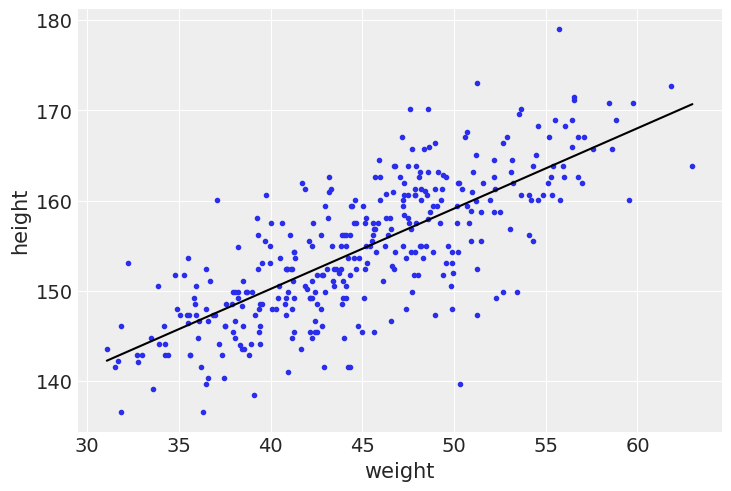

In [7]:
# Visualise

az.plot_pair(data[["weight", "height"]].to_dict(orient="list"))
post = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(data.weight.min(), data.weight.max(), 101)
plt.plot(x, a_map + b_map * (x), "k")
plt.show()

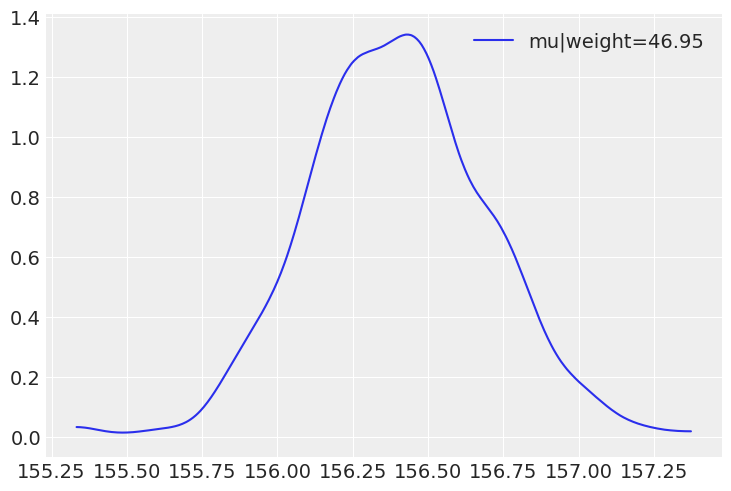

156.39897


DeviceArray([155.94603, 156.86385], dtype=float32)

In [8]:
# Perform prediction for one value

post = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
prediction = post["a"] + post["b"] * (46.95)

# Visualise
az.plot_kde(prediction, label="mu|weight=46.95")
plt.show()

# Get expected value
print(prediction.mean())

# Get 89% probability interval
jnp.percentile(prediction, q=(5.5, 94.5))

In [9]:
# Iterate for all values

weights = [46.95, 43.72, 64.78, 32.59, 54.63]
for w in weights:
    post = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
    prediction = post["a"] + post["b"] * (w)
    mean = float(prediction.mean())
    pi = jnp.percentile(prediction, q=(5.5, 94.5))
    print(f"| weight={w} | mean={round(mean, 2)} | 89% pi={pi}")

| weight=46.95 | mean=156.4 | 89% pi=[155.94603 156.86385]
| weight=43.72 | mean=153.52 | 89% pi=[153.08966 153.98033]
| weight=64.78 | mean=172.28 | 89% pi=[170.9952  173.79353]
| weight=32.59 | mean=143.61 | 89% pi=[142.67596 144.57721]
| weight=54.63 | mean=163.24 | 89% pi=[162.52702 164.10341]


In [10]:
# 4H2
# (a)

data = raw[raw["age"] < 18]
# Make the average height smaller since the people are shorter now.

# Define model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 50))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Train model
trained_model = AutoLaplaceApproximation(model)
svi = SVI(
    model, trained_model, optim.Adam(1), Trace_ELBO(), weight=data.weight.values, height=data.height.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
trained_parameters = svi.get_params(state)

# Summary statistics
samples = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     84.44      8.30     84.71     70.67     96.87    931.50      1.00
         b      1.60      0.42      1.52      0.95      2.23    962.82      1.00
     sigma     25.50     25.01     50.00      0.00     50.00    998.80      1.00



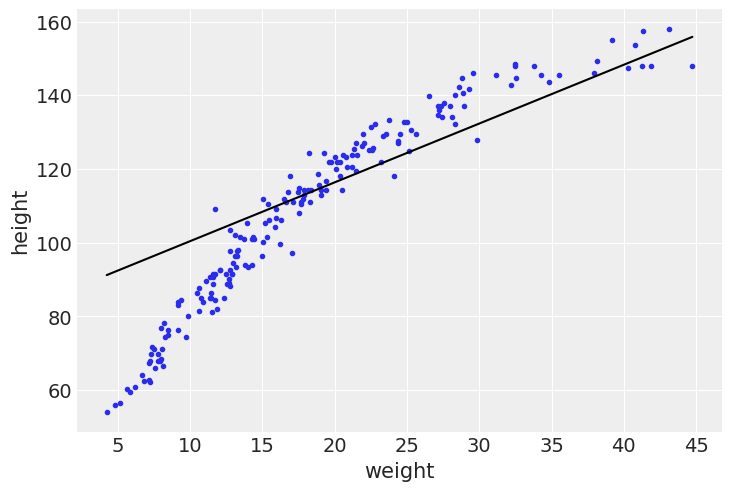

In [11]:
# Visualise

az.plot_pair(data[["weight", "height"]].to_dict(orient="list"))
post = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
a_map = jnp.mean(post["a"])
b_map = jnp.mean(post["b"])
x = jnp.linspace(data.weight.min(), data.weight.max(), 101)
plt.plot(x, a_map + b_map * x, "k")
plt.show()

Parameter b measures the gradient. As $\overline{b}=1.60$, for every 10 kg of weight the model predicts on average the height will increase by 16.0 cm.

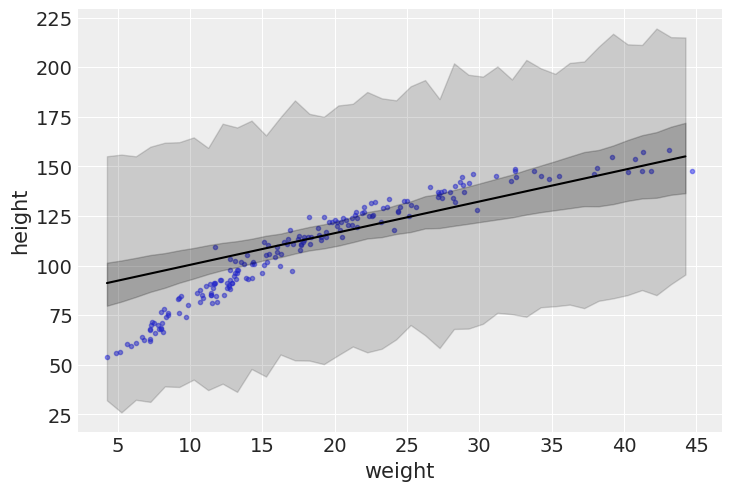

In [12]:
# (b)

# Plotting with 89% PI of height and 89% PI of mean (darker shade)
post = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight)
weight_seq = jnp.arange(start=min(data.weight), stop=max(data.weight), step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

sim_height = Predictive(trained_model.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)

# plot
az.plot_pair(
    data[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

(c)

Linear model not appropriate for the data. The 89% uncertainty in confidence interval is very broad. Was interesting to reduce the Normal sigma for height and see how that changes things. Realistically a prior with lower mean height would also make more sense.


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    -22.64      1.35    -22.60    -24.89    -20.62    931.50      1.00
         b     46.75      0.39     46.74     46.17     47.39    938.38      1.00
     sigma      5.15      0.16      5.15      4.91      5.41    948.76      1.00

[0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.         1.1
 1.2        1.3000001  1.4        1.5        1.6        1.7
 1.8000001  1.9        2.         2.1000001  2.2        2.3
 2.4        2.5        2.6000001  2.7        2.8        2.9
 3.         3.1000001  3.2        3.3        3.4        3.5
 3.6000001  3.7        3.8        3.9        4.         4.1
 4.2000003  4.3        4.4        4.5        4.6        4.7000003
 4.8        4.9       ]


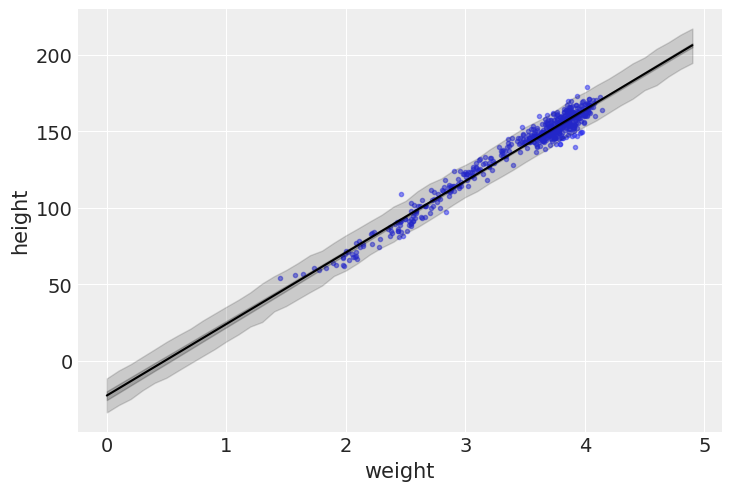

In [13]:
# 4H3 (a, b)

# Just going to do this by converting all weight measurements into the log space.
import numpy as np

data = raw
data.weight = np.log(raw.weight)

# Define model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 50))
    b = numpyro.sample("b", dist.Normal(0, 5))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Train model
trained_model = AutoLaplaceApproximation(model)
svi = SVI(
    model, trained_model, optim.Adam(1), Trace_ELBO(), weight=data.weight.values, height=data.height.values
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
trained_parameters = svi.get_params(state)

# Summary statistics
samples = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
samples.pop("mu")
print_summary(samples, 0.89, False)

# Plotting with 89% PI of height and 89% PI of mean (darker shade)
post = trained_model.sample_posterior(random.PRNGKey(1), trained_parameters, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * weight
weight_seq = jnp.arange(start=0, stop=5, step=0.1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = jnp.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.97, axis=0)
print(weight_seq)

sim_height = Predictive(trained_model.model, post, return_sites=["height"])(
    random.PRNGKey(2), weight_seq, None
)["height"]
sim_height.shape, list(sim_height[:5, 0])

height_PI = jnp.percentile(sim_height, q=(1.5, 98.5), axis=0)

# plot
az.plot_pair(
    data[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

Not as easy to interpret as the weight axis no longer makes sense. But the model appears to fit better. Hard to determine how much better as the data becomes dense in one part of the curve.


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    146.05      0.36    146.03    145.47    146.58   1049.96      1.00
        b1     21.77      0.30     21.77     21.26     22.19    886.88      1.00
        b2     -7.79      0.28     -7.79     -8.21     -7.32   1083.60      1.00
     sigma      5.79      0.17      5.79      5.49      6.03    973.65      1.00



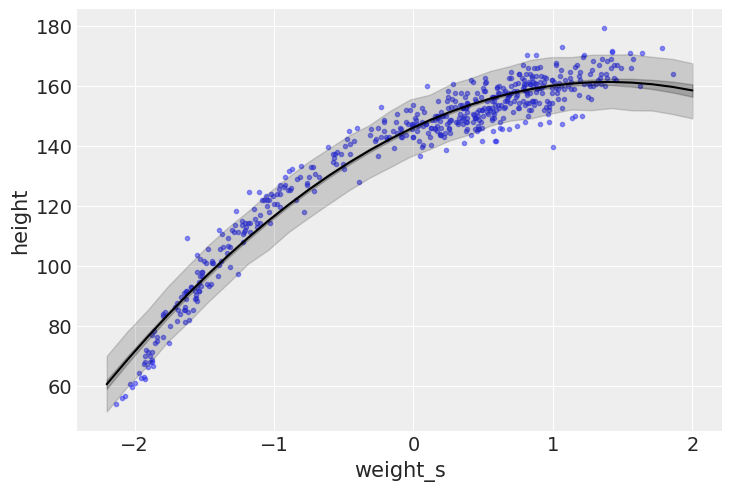

In [22]:
# 4H4

raw = pd.read_csv("data/Howell_Kung.csv")
d = raw
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2


def model(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight_s=d.weight_s.values,
    weight_s2=d.weight_s2.values,
    height=d.height.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p4_5 = svi.get_params(state)

# summary statistics
samples = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
print_summary({k: v for k, v in samples.items() if k != "mu"}, 0.89, False)

# plot PIs
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2}
post = m4_5.sample_posterior(random.PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post)
mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=(5.5, 94.5), axis=0)
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()